In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ninja
!pip install rembg
!pip install mediapipe

## Cloth Segmentation

In [ ]:
import os
from PIL import Image
import numpy as np
from collections import OrderedDict

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import sys
device = 'cuda'

image_dir = '/content/drive/MyDrive/cloth'
result_dir = '/content/drive/MyDrive/cloth-mask'
checkpoint_path = '/content/drive/MyDrive/clothes-virtual-try-on/cloth_segm_u2net_latest.pth' # path for pretrained model

sys.path.insert(1, "/content/drive/MyDrive/clothes-virtual-try-on/")
sys.path.insert(1, "/content/drive/MyDrive/Capstone_Project/")  # appending the path

from networks.u2net import U2NET

def load_checkpoint_mgpu(model, checkpoint_path):
    if not os.path.exists(checkpoint_path):     ### checking the pretrained model
        print("----No checkpoints at given path----")
        return
    model_state_dict = torch.load(checkpoint_path, map_location=torch.device("cpu"))   # loading the pretrained model
    new_state_dict = OrderedDict()
    for k, v in model_state_dict.items():   # performing necessary adjustment for loading the model according to our system
        name = k[7:]  # remove `module.`
        new_state_dict[name] = v

    model.load_state_dict(new_state_dict)
    print("----checkpoints loaded from path: {}----".format(checkpoint_path))
    return model

class Normalize_image(object):
    """Normalize given tensor into given mean and standard dev

    Args:
        mean (float): Desired mean to substract from tensors
        std (float): Desired std to divide from tensors
    """

    def __init__(self, mean, std):
        assert isinstance(mean, (float))
        if isinstance(mean, float):
            self.mean = mean

        if isinstance(std, float):
            self.std = std

        self.normalize_1 = transforms.Normalize(self.mean, self.std)    # depending on number of channels, normalization is created
        self.normalize_3 = transforms.Normalize([self.mean] * 3, [self.std] * 3)
        self.normalize_18 = transforms.Normalize([self.mean] * 18, [self.std] * 18)

    def __call__(self, image_tensor):
        if image_tensor.shape[0] == 1:
            return self.normalize_1(image_tensor)

        elif image_tensor.shape[0] == 3:
            return self.normalize_3(image_tensor)  # we usually have three channel images

        elif image_tensor.shape[0] == 18:
            return self.normalize_18(image_tensor)

        else:
            assert "Please set proper channels! Normlization implemented only for 1, 3 and 18"


def get_palette(num_cls):
    """ Returns the color map for visualizing the segmentation mask.
    Args:
        num_cls: Number of classes
    Returns:
        The color map
    """
    n = num_cls
    palette = [0] * (n * 3)
    for j in range(0, n):
        lab = j
        palette[j * 3 + 0] = 0
        palette[j * 3 + 1] = 0
        palette[j * 3 + 2] = 0
        i = 0
        while lab:
            palette[j * 3 + 0] = 255
            palette[j * 3 + 1] = 255
            palette[j * 3 + 2] = 255
            # palette[j * 3 + 0] |= (((lab >> 0) & 1) << (7 - i))
            # palette[j * 3 + 1] |= (((lab >> 1) & 1) << (7 - i))
            # palette[j * 3 + 2] |= (((lab >> 2) & 1) << (7 - i))
            i += 1
            lab >>= 3
    return palette


transforms_list = []
transforms_list += [transforms.ToTensor()]
transforms_list += [Normalize_image(0.5, 0.5)]
transform_rgb = transforms.Compose(transforms_list)  ## image is normalized here, using the Normalize image class

net = U2NET(in_ch=3, out_ch=4)  #initialization
net = load_checkpoint_mgpu(net, checkpoint_path) # loading pretrained model
net = net.to(device)  # putting into cpu/gpu
net = net.eval()

palette = get_palette(4)

images_list = sorted(os.listdir(image_dir))
for image_name in images_list:
    img = Image.open(os.path.join(image_dir, image_name)).convert('RGB')
    img_size = img.size
    img = img.resize((768, 768), Image.BICUBIC)   # resize image to fit into model
    image_tensor = transform_rgb(img)   #normalization
    image_tensor = torch.unsqueeze(image_tensor, 0)  # If a layer requires a minimum of 4D and your tensor is 3D we do this, adds an extra dimension  r,g,b , 1

    output_tensor = net(image_tensor.to(device))  #getting classes of image pixels cloth/not cloth
    output_tensor = F.log_softmax(output_tensor[0], dim=1)  # softmax is applied to the output tensor (for probability)
    output_tensor = torch.max(output_tensor, dim=1, keepdim=True)[1]  # argmax is applied to the output tensor
    output_tensor = torch.squeeze(output_tensor, dim=0) # back to original dimensions after output
    output_tensor = torch.squeeze(output_tensor, dim=0)  #tensor type
    output_arr = output_tensor.cpu().numpy() # converted to numpy array

    output_img = Image.fromarray(output_arr.astype('uint8'), mode='L')   # numpy array to be converted into image object in grayscale
    output_img = output_img.resize(img_size, Image.BICUBIC)

    output_img.putpalette(palette)  #put palette into image , black and white 3 dimensions
    output_img = output_img.convert('L')  # greyscale use 1 dimension
    output_img.save(os.path.join(result_dir, image_name[:-4]+'.jpg'))

----checkpoints loaded from path: /content/drive/MyDrive/clothes-virtual-try-on/cloth_segm_u2net_latest.pth----


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


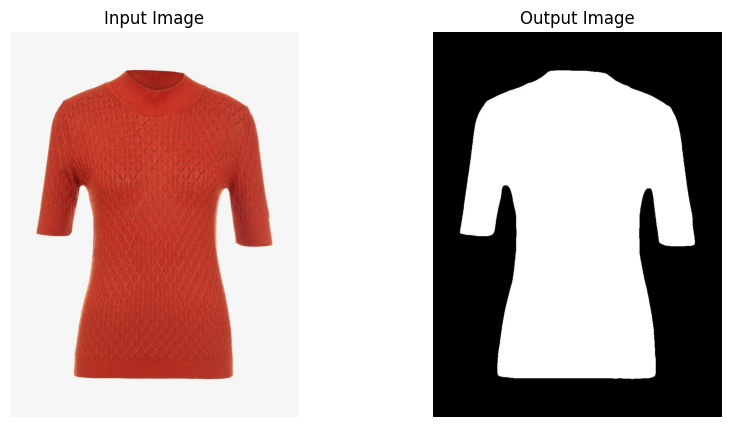

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Path to your images
input_image_path = '/content/drive/MyDrive/Capstone_Project/datasets/test/cloth/01260_00.jpg'
output_image_path = '/content/drive/MyDrive/Capstone_Project/datasets/test/cloth-mask/01260_00.jpg'

# Load the images
input_image = Image.open(input_image_path)
output_image = Image.open(output_image_path)

# Create a figure to display the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the input image
axes[0].imshow(input_image)
axes[0].set_title('Input Image')
axes[0].axis('off')  # Turn off axis numbers and ticks

# Display the output image
axes[1].imshow(output_image,cmap ='gray')
axes[1].set_title('Output Image')
axes[1].axis('off')

# Show the plot
plt.show()


## Body Parsing

In [ ]:
!python3 '/content/drive/MyDrive/Self-Correction-Human-Parsing/simple_extractor.py' --dataset 'lip' --model-restore '/content/drive/MyDrive/Self-Correction-Human-Parsing/checkpoints/final.pth' --input-dir '/content/drive/MyDrive/model_2/' --output-dir '/content/drive/MyDrive/image-parse/'

main
start
Evaluating total class number 20 with ['Background', 'Hat', 'Hair', 'Glove', 'Sunglasses', 'Upper-clothes', 'Dress', 'Coat', 'Socks', 'Pants', 'Jumpsuits', 'Scarf', 'Skirt', 'Face', 'Left-arm', 'Right-arm', 'Left-leg', 'Right-leg', 'Left-shoe', 'Right-shoe']
here
100% 1/1 [00:01<00:00,  1.66s/it]


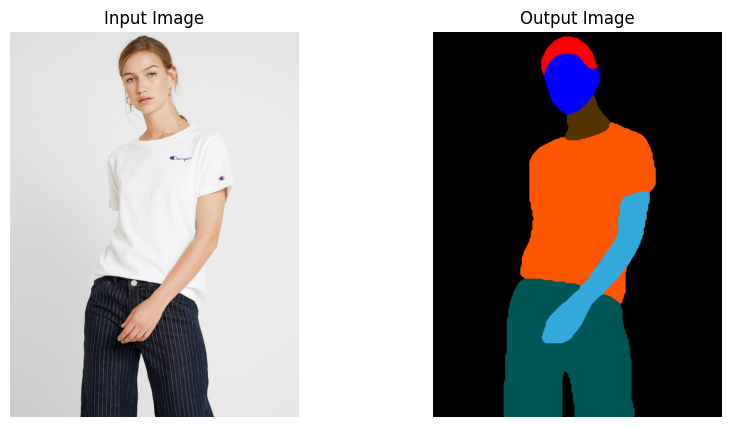

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Path to your images
input_image_path = '/content/drive/MyDrive/Capstone_Project/datasets/test/image/00891_00.jpg'
output_image_path = '/content/drive/MyDrive/Capstone_Project/datasets/test/image-parse/00891_00.png'

# Load the images
input_image = Image.open(input_image_path)
output_image = Image.open(output_image_path)

# Create a figure to display the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the input image
axes[0].imshow(input_image)
axes[0].set_title('Input Image')
axes[0].axis('off')  # Turn off axis numbers and ticks

# Display the output image
axes[1].imshow(output_image,cmap ='gray')
axes[1].set_title('Output Image')
axes[1].axis('off')

# Show the plot
plt.show()


## Pose Detection

In [ ]:
import cv2
import mediapipe as mp

# Initialize MediaPipe Hands and Pose models
mp_hands = mp.solutions.hands
mp_pose = mp.solutions.pose
# Define drawing tools
mp_drawing = mp.solutions.drawing_utils
# Initialize MediaPipe Hands and Pose instances
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)     ## HAnds object
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)  # Pose object initialization

# Function to process image
def process_image(image):
    # Convert the image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Process hand detection
    results_hands = hands.process(image_rgb)
    # Process pose estimation
    results_pose = pose.process(image_rgb)

    return results_hands, results_pose

# Function to display results
def display_results(image, results_hands, results_pose):
    if results_hands.multi_hand_landmarks:
        for hand_landmarks in results_hands.multi_hand_landmarks:
            # Draw hand landmarks on the image
            mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
    if results_pose.pose_landmarks:
        # Draw pose landmarks on the image
        mp_drawing.draw_landmarks(image, results_pose.pose_landmarks, mp_pose.POSE_CONNECTIONS)

    # Display the image with detected landmarks
    cv2.imwrite("/content/drive/MyDrive/model/pose.jpg", image)
    # cv2.waitKey(0)

# Load image
image = cv2.imread(input_image_path)

# Process image
results_hands, results_pose = process_image(image)

# Display results
display_results(image, results_hands, results_pose)

# Release resources
hands.close()
pose.close()


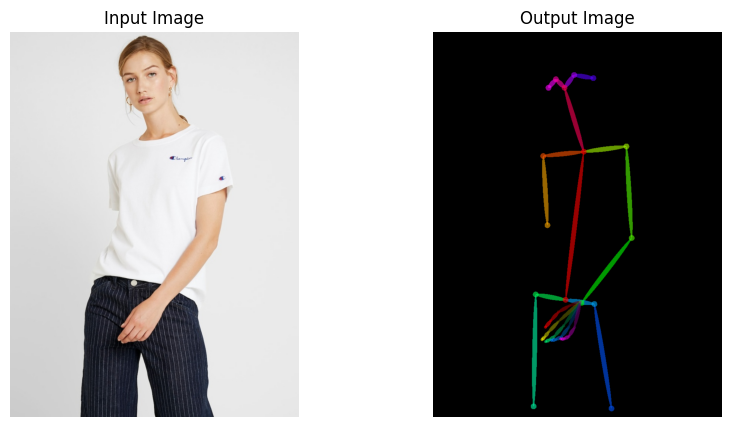

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Path to your images
input_image_path = '/content/drive/MyDrive/Capstone_Project/datasets/test/image/00891_00.jpg'
output_image_path = '/content/drive/MyDrive/Capstone_Project/datasets/test/openpose-img/00891_00_rendered.png'

# Load the images
input_image = Image.open(input_image_path)
output_image = Image.open(output_image_path)

# Create a figure to display the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the input image
axes[0].imshow(input_image)
axes[0].set_title('Input Image')
axes[0].axis('off')  # Turn off axis numbers and ticks

# Display the output image
axes[1].imshow(output_image,cmap ='gray')
axes[1].set_title('Output Image')
axes[1].axis('off')

# Show the plot
plt.show()


## Keypoints Detection

In [ ]:
import cv2
import mediapipe as mp
import json

# Initialize MediaPipe Hands and Pose models
mp_hands = mp.solutions.hands
mp_pose = mp.solutions.pose

# Initialize MediaPipe Hands and Pose instances
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Define drawing tools
mp_drawing = mp.solutions.drawing_utils

# Function to process image
def process_image(image):
    # Convert the image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Process hand detection
    results_hands = hands.process(image_rgb)
    # Process pose estimation
    results_pose = pose.process(image_rgb)

    return results_hands, results_pose

# Function to save keypoints to JSON file
def save_keypoints_to_json(results_hands, results_pose, json_file):
    data = {}

    if results_hands.multi_hand_landmarks:   # convert into the openpose format for hands
        data["hands"] = []
        for hand_landmarks in results_hands.multi_hand_landmarks:
            hand_keypoints = [{'x': landmark.x, 'y': landmark.y, 'z': landmark.z} for landmark in hand_landmarks.landmark]
            data["hands"].append(hand_keypoints)

    if results_pose.pose_landmarks:   # convert into the openpose format for pose
        pose_keypoints = [{'x': landmark.x, 'y': landmark.y, 'z': landmark.z} for landmark in results_pose.pose_landmarks.landmark]
        data["pose"] = pose_keypoints

    with open(json_file, 'w') as f:
        json.dump(data, f, indent=4) # write to json file

# Load image
image = cv2.imread(input_image_path)

# Process image
results_hands, results_pose = process_image(image)

# Save keypoints to JSON file
save_keypoints_to_json(results_hands, results_pose, "/content/drive/MyDrive/Capstone_Project/datasets/test/openpose-json/00891_00_keypoints.json")

# Release resources
hands.close()
pose.close()


In [ ]:
import json

# Path to your JSON file
file_path = '/content/drive/MyDrive/Capstone_Project/datasets/test/openpose-json/00891_00_keypoints.json'

# Open the file and load the data
with open(file_path, 'r') as file:
    data = json.load(file)

# Print the loaded data
print(json.dumps(data, indent=4))


{
    "version": 1.3,
    "people": [
        {
            "person_id": [
                -1
            ],
            "pose_keypoints_2d": [
                349.091,
                147.821,
                0.922318,
                400.138,
                317.836,
                0.770555,
                292.373,
                329.363,
                0.741053,
                303.693,
                513.417,
                0.217837,
                0,
                0,
                0,
                513.438,
                303.726,
                0.68234,
                527.623,
                547.373,
                0.808538,
                394.255,
                720.279,
                0.750887,
                351.821,
                711.821,
                0.523726,
                272.552,
                697.645,
                0.468322,
                266.87,
                995.149,
                0.224299,
                0,
                0,
   

In [ ]:
!python /content/drive/MyDrive/Capstone_Project/test.py --name result --dataset_dir /content/drive/MyDrive/Capstone_Project/datasets/ --checkpoint_dir /content/drive/MyDrive/Capstone_Project/checkpoints/ --save_dir /content/drive/MyDrive/Capstone_Project/Image-Selector-main/Image-Selector-main/static/images/

Namespace(name='result', batch_size=1, workers=1, load_height=1024, load_width=768, shuffle=False, dataset_dir='/content/drive/MyDrive/Capstone_Project/datasets/', dataset_mode='test', dataset_list='test_pairs.txt', checkpoint_dir='/content/drive/MyDrive/Capstone_Project/checkpoints/', save_dir='/content/drive/MyDrive/Capstone_Project/Image-Selector-main/Image-Selector-main/static/images/', display_freq=1, seg_checkpoint='seg_final.pth', gmm_checkpoint='gmm_final.pth', alias_checkpoint='alias_final.pth', semantic_nc=13, init_type='xavier', init_variance=0.02, grid_size=5, norm_G='spectralaliasinstance', ngf=64, num_upsampling_layers='most')
Network [SegGenerator] was created. Total number of parameters: 34.5 million. To see the architecture, do print(network).
Network [ALIASGenerator] was created. Total number of parameters: 100.5 million. To see the architecture, do print(network).
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is

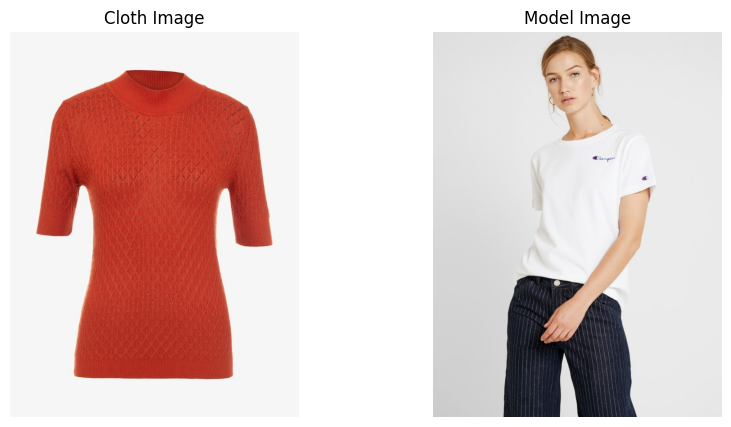

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Path to your images
input_image_path = '/content/drive/MyDrive/Capstone_Project/datasets/test/cloth/01260_00.jpg'
output_image_path = '/content/drive/MyDrive/Capstone_Project/datasets/test/image/00891_00.jpg'

# Load the images
input_image = Image.open(input_image_path)
output_image = Image.open(output_image_path)

# Create a figure to display the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the input image
axes[0].imshow(input_image)
axes[0].set_title('Cloth Image')
axes[0].axis('off')  # Turn off axis numbers and ticks

# Display the output image
axes[1].imshow(output_image,cmap ='gray')
axes[1].set_title('Model Image')
axes[1].axis('off')

# Show the plot
plt.show()


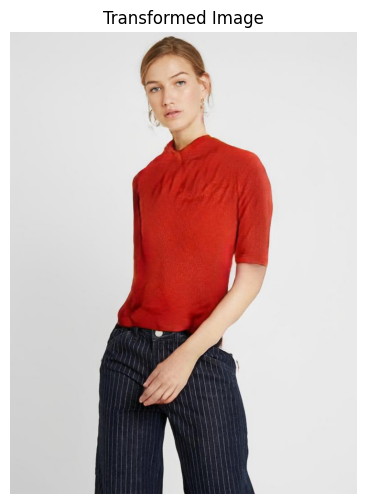

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Path to your output image
output_image_path = '/content/drive/MyDrive/Capstone_Project/Image-Selector-main/Image-Selector-main/static/images/result/result.jpg'

# Load the image
output_image = Image.open(output_image_path)

# Create a figure to display the image
plt.figure(figsize=(6, 6))

# Display the image
plt.imshow(output_image, cmap='gray')
plt.title('Transformed Image')
plt.axis('off')

# Show the plot
plt.show()
